In [1]:
import sys
sys.path.append("../")  # go to parent directory

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from src.utils import read_csv, get_sentiment_mapping
from transformers import BertTokenizerFast, BertForSequenceClassification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
RANDOM_SEED = 42  # for reproducibilty
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

PATH_TO_DATA = "../data/validation.csv"
MAX_LENGTH = 100
BATCH_SIZE = 20

SENT_LABELS = ['Irrelevant', 'Neutral', 'Negative', 'Positive']

In [3]:
col_names = ['Id','Entity','Sentiment','Text']
unseen_df = read_csv(path=PATH_TO_DATA, col_names=col_names)
unseen_df.head(5)

,Id,Entity,Sentiment,Text
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


In [4]:
sent_labels = unseen_df['Sentiment'].unique().tolist()
sent_labels

['Irrelevant', 'Neutral', 'Negative', 'Positive']

In [5]:
# Load the saved model and tokenizer
model = BertForSequenceClassification.from_pretrained('../bert_model')
tokenizer = BertTokenizerFast.from_pretrained('../bert_model')

# Ensure the model is in evaluation mode
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [6]:
# Tokenize the unseen data
unseen_encodings = tokenizer(list(unseen_df['Sentiment']), truncation=True, padding=True, max_length=MAX_LENGTH)

In [7]:
# Create a custom dataset for PyTorch
class UnseenDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __len__(self):
        return len(self.encodings['input_ids'])

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        return item

In [8]:
# Create the dataset and dataloader
unseen_dataset = UnseenDataset(unseen_encodings)
unseen_loader = DataLoader(unseen_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [9]:
# Move the model to GPU if available
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [10]:
# Make predictions
predictions = []

with torch.no_grad():
    for batch in unseen_loader:
        inputs = {key: val.to(device) for key, val in batch.items()}
        outputs = model(**inputs)
        preds = torch.argmax(outputs.logits, dim=1)
        predictions.extend(preds.cpu().numpy())


In [11]:
# Map predictions to sentiment labels
sentiment_mapping = get_sentiment_mapping(sent_list=SENT_LABELS)
sentiment_mapping

{0: 'Irrelevant', 1: 'Neutral', 2: 'Negative', 3: 'Positive'}

In [12]:
predicted_labels = [sentiment_mapping[pred] for pred in predictions]
true_labels = unseen_df['Sentiment'].values

In [13]:
# Compute the confusion matrix
conf_mtx = confusion_matrix(true_labels, predicted_labels, labels=sent_labels)

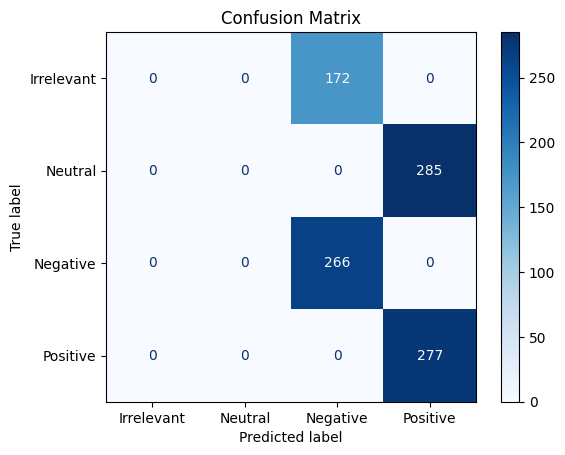

In [14]:
# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mtx, display_labels=SENT_LABELS)
disp.plot(cmap=plt.cm.Blues)

# Show the plot
plt.title('Confusion Matrix')
plt.show()

In [15]:
# Add predictions to the unseen data
unseen_df['Predicted_Sentiment'] = predicted_labels

# Save the results to a new CSV file
unseen_df.to_csv('../data/predicted_unseen_data.csv', index=False)

# Display the first few rows of the results
unseen_df.head()

,Id,Entity,Sentiment,Text,Predicted_Sentiment
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...,Negative
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...,Positive
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...,Negative
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,...",Negative
4,4433,Google,Neutral,Now the President is slapping Americans in the...,Positive
